In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pickle

from matplotlib import animation, rc
from IPython.display import HTML

In [3]:
game_logs_data = pd.read_csv('2000-2021 Season Game Logs with Advanced Stats.csv',index_col=0,dtype={'GAME_ID':'str'})
all_ssns_avgs_data = pd.read_csv('all_seasons_avg_stats.csv',index_col=0,dtype={'GAME_ID':'str'})

C:\Users\arthu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (69) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
all_ssns_avgs_data.head()

,SEASON_YEAR,PLAYER_NAME,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,...,FGA_P100,FTM_P100,FTA_P100,FG3M_P100,FG3A_P100,SSN_FG_PCT,SSN_FT_PCT,SSN_FG3_PCT,SSN_EFG_PCT,SSN_TS_PCT
0,2000-01,A.C. Green,90.895122,93.108537,0.040268,0.140610,7.292683,0.072439,0.151110,0.109402,...,12.180451,2.969925,4.172932,0.000000,0.225564,0.444444,0.711712,0.000000,0.444444,0.492168
1,2000-01,A.J. Guyton,84.721212,100.218182,0.196970,1.116061,20.524242,0.016273,0.038909,0.027667,...,16.368286,1.278772,1.534527,2.301790,5.882353,0.406250,0.833333,0.391304,0.476562,0.495198
2,2000-01,Aaron McKie,101.314474,95.788158,0.255368,1.990789,26.535526,0.014868,0.113355,0.065513,...,15.391248,3.211899,4.181936,1.142488,3.664583,0.473389,0.768041,0.311765,0.510504,0.549189
3,2000-01,Aaron Williams,95.898780,104.706098,0.065415,0.533293,8.285366,0.091220,0.176646,0.130598,...,14.361467,5.391074,6.849315,0.000000,0.044189,0.456923,0.787097,0.000000,0.456923,0.532808
4,2000-01,Adam Keefe,89.428358,104.811940,0.052791,0.417910,8.883582,0.090269,0.127299,0.110478,...,9.532374,2.338129,3.776978,0.059952,0.179856,0.402516,0.619048,0.333333,0.405660,0.449871


In [5]:
print(all_ssns_avgs_data.columns)
print(len(all_ssns_avgs_data))

Index(['SEASON_YEAR', 'PLAYER_NAME', 'OFF_RATING', 'DEF_RATING', 'AST_PCT',
       'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'USG_PCT',
       'POSS', 'PIE', 'REB_P100', 'AST_P100', 'STL_P100', 'BLK_P100',
       'PTS_P100', 'FGM_P100', 'FGA_P100', 'FTM_P100', 'FTA_P100', 'FG3M_P100',
       'FG3A_P100', 'SSN_FG_PCT', 'SSN_FT_PCT', 'SSN_FG3_PCT', 'SSN_EFG_PCT',
       'SSN_TS_PCT'],
      dtype='object')
8415


In [6]:
# monthly team win loss records

game_logs_data['GAME_MONTH'] = game_logs_data['GAME_DATE'].str[:7]
game_logs_data['OPP'] = game_logs_data['MATCHUP'].str[-3:]

monthly_team_win_loss = game_logs_data[['SEASON_YEAR','TEAM_ID','TEAM_NAME','TEAM_ABBREVIATION','GAME_MONTH','GAME_ID','WL']].drop_duplicates()

monthly_team_win_loss_records = monthly_team_win_loss.groupby(by=['SEASON_YEAR','GAME_MONTH','TEAM_NAME','TEAM_ABBREVIATION','WL']).size().reset_index().pivot_table(index=['SEASON_YEAR','GAME_MONTH','TEAM_NAME','TEAM_ABBREVIATION'],columns='WL',values=0)
monthly_team_win_loss_records = monthly_team_win_loss_records.reset_index()
monthly_team_win_loss_records['win_%'] = monthly_team_win_loss_records['W'] / (monthly_team_win_loss_records['W'] + monthly_team_win_loss_records['L'])

monthly_team_win_loss_records.fillna(0,inplace=True)

monthly_team_win_loss_records = monthly_team_win_loss_records.reset_index(drop=True)
monthly_team_win_loss_records['GAME_MONTH_DATE'] = pd.to_datetime(monthly_team_win_loss_records['GAME_MONTH'])

for row_index in range(len(monthly_team_win_loss_records)):
    current_year = monthly_team_win_loss_records.loc[row_index,'SEASON_YEAR']
    current_team = monthly_team_win_loss_records.loc[row_index,'TEAM_NAME']
    current_month_date = monthly_team_win_loss_records.loc[row_index,'GAME_MONTH_DATE']
    
    year_filter = monthly_team_win_loss_records['SEASON_YEAR'] == current_year
    team_filter = monthly_team_win_loss_records['TEAM_NAME'] == current_team
    month_filter = monthly_team_win_loss_records['GAME_MONTH_DATE'] < current_month_date
    combined_filter = (year_filter)&(team_filter)&(month_filter)
    
    if len(monthly_team_win_loss_records[combined_filter])>0:
        num_losses = sum(monthly_team_win_loss_records[combined_filter]['L'])
        num_wins = sum(monthly_team_win_loss_records[combined_filter]['W'])
        cumulative_win_percent = num_wins/(num_wins + num_losses)
    else:
        # use an estimate if first month of the season
        cumulative_win_percent = .5
        
    monthly_team_win_loss_records.loc[row_index,'cumulative_win_%'] = cumulative_win_percent

# get opponent w/l records and minutes

opp_records = game_logs_data[['SEASON_YEAR','TEAM_ID','TEAM_NAME','TEAM_ABBREVIATION','GAME_MONTH','GAME_ID','OPP']].drop_duplicates()
opp_records = pd.merge(opp_records,monthly_team_win_loss_records[['GAME_MONTH','TEAM_ABBREVIATION','cumulative_win_%']],how='left',left_on=['GAME_MONTH','OPP'],right_on=['GAME_MONTH','TEAM_ABBREVIATION'],suffixes=('','_2'),validate="m:1")
opp_records = opp_records.groupby(by=['GAME_MONTH','TEAM_ABBREVIATION']).agg({'cumulative_win_%':'mean'})

opp_records.reset_index(inplace=True)
opp_records.columns = ['GAME_MONTH','TEAM_ABBREVIATION','opp_avg_cumulative_win_%']

monthly_team_win_loss_records= pd.merge(monthly_team_win_loss_records,opp_records,on=['GAME_MONTH','TEAM_ABBREVIATION'])


In [7]:
monthly_team_win_loss_records.sample(3)

,SEASON_YEAR,GAME_MONTH,TEAM_NAME,TEAM_ABBREVIATION,L,W,win_%,GAME_MONTH_DATE,cumulative_win_%,opp_avg_cumulative_win_%
4037,2020-21,2020-12,Portland Trail Blazers,POR,2.0,2.0,0.5000,2020-12-01,0.500000,0.500000
15,2000-01,2000-10,Orlando Magic,ORL,0.0,1.0,0.0000,2000-10-01,0.500000,0.500000
502,2002-03,2003-01,Miami Heat,MIA,11.0,5.0,0.3125,2003-01-01,0.366667,0.530953


In [8]:
with open("scaler2.pkl", "rb") as f:
    scaler = pickle.load(f)
    
with open("pca2.pkl", "rb") as f:
    pca = pickle.load(f)
    
# with open("kmeans2.pkl", "rb") as f:
#     kmeans = pickle.load(f)
    
# cluster labels manually interpreted from notebook 4
cluster_labels = {0:"Situational/Defensive Players",1:"High Usage Dominant Scorers",2:"Stretch Forward",3:"Low End All Around Players",4:"Playmakers",5:"3 Point Specialist",6:"Traditional Big Men"}

In [9]:
def create_data_for_win_rate_preds(k, scaler_pkl, pca_pkl, all_ssns_avgs_data, game_logs_data, monthly_team_win_loss_records):
    
    with open("kmeans_k_{k}.pkl".format(k=k), "rb") as f:
        kmeans = pickle.load(f)
    
    # Add cluster value for each player/season combo 
    clusters = kmeans.predict(pca_pkl.transform(scaler_pkl.fit_transform(all_ssns_avgs_data.iloc[:,2:].to_numpy())))
    all_ssns_avgs_data_w_clusters = all_ssns_avgs_data.copy()
    all_ssns_avgs_data_w_clusters['cluster'] = clusters
    
    all_ssns_avgs_data_w_clusters.to_csv('all_seasons_avg_stats_w_{k}_cluster_data.csv'.format(k=k))
    
    game_logs_data_with_clusters = pd.merge(game_logs_data, all_ssns_avgs_data_w_clusters[['SEASON_YEAR','PLAYER_NAME','cluster']],  how='left', left_on=['SEASON_YEAR','PLAYER_NAME'], right_on = ['SEASON_YEAR','PLAYER_NAME'])
#     game_logs_data_with_clusters.to_csv('2000-2021 Season Game Logs with Advanced Stats - {k} Clusters.csv'.format(k=k))
       
    monthly_team_cluster_data = game_logs_data_with_clusters.groupby(by=['GAME_MONTH','TEAM_ABBREVIATION','cluster']).agg({'PLAYER_NAME':['count'],'MIN':['sum','mean'],'PTS':['sum','mean']})

    # append if there was a multi-index i.e. MIN_SUM
    monthly_team_cluster_data.columns = [col_name[0] + ("_"*(len(col_name[1])>0)) + col_name[1] for col_name in monthly_team_cluster_data.columns]

    # create cluster percentage
    monthly_team_cluster_data["MIN_%"]= 0

    unique_monthly_records = list(set([(index_value[0],index_value[1]) for index_value in monthly_team_cluster_data.index.to_list()]))

    for team_month in unique_monthly_records:
        total_minutes = monthly_team_cluster_data.loc[team_month]['MIN_sum'].sum()
        for cluster_no in range(k):
            try:
                min_percent = monthly_team_cluster_data.loc[(team_month[0],team_month[1],cluster_no),"MIN_sum"]/total_minutes
                monthly_team_cluster_data.loc[(team_month[0],team_month[1],cluster_no),'MIN_%'] = min_percent
            except: # if cluster doesn't already exist
                monthly_team_cluster_data.loc[(team_month[0],team_month[1],cluster_no),'MIN_%'] = 0
    
    monthly_team_cluster_data = monthly_team_cluster_data.sort_index().reset_index()
    
    final_monthly_data = pd.merge(monthly_team_win_loss_records,monthly_team_cluster_data,  how='left', left_on=['GAME_MONTH','TEAM_ABBREVIATION'], right_on=['GAME_MONTH','TEAM_ABBREVIATION'])
    final_monthly_data.to_csv('monthly_win_rates - {k} cluster data.csv'.format(k=k))





In [10]:
# for k in range(2, 31):
for k in range(24, 31):
    print(k)
    create_data_for_win_rate_preds(k, scaler, pca, all_ssns_avgs_data, game_logs_data, monthly_team_win_loss_records)

24


C:\Users\arthu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2940: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
<ipython-input-9-d0570279963a>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  total_minutes = monthly_team_cluster_data.loc[team_month]['MIN_sum'].sum()


25


C:\Users\arthu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2940: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
<ipython-input-9-d0570279963a>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  total_minutes = monthly_team_cluster_data.loc[team_month]['MIN_sum'].sum()


26


C:\Users\arthu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2940: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
<ipython-input-9-d0570279963a>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  total_minutes = monthly_team_cluster_data.loc[team_month]['MIN_sum'].sum()


27


C:\Users\arthu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2940: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
<ipython-input-9-d0570279963a>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  total_minutes = monthly_team_cluster_data.loc[team_month]['MIN_sum'].sum()


28


C:\Users\arthu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2940: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
<ipython-input-9-d0570279963a>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  total_minutes = monthly_team_cluster_data.loc[team_month]['MIN_sum'].sum()


29


C:\Users\arthu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2940: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
<ipython-input-9-d0570279963a>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  total_minutes = monthly_team_cluster_data.loc[team_month]['MIN_sum'].sum()


30


C:\Users\arthu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2940: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
<ipython-input-9-d0570279963a>:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  total_minutes = monthly_team_cluster_data.loc[team_month]['MIN_sum'].sum()


In [7]:
clusters = kmeans.predict(pca.transform(scaler.fit_transform(all_ssns_avgs_data.iloc[:,2:].to_numpy())))

all_ssns_avgs_data['cluster'] = clusters

In [8]:
all_ssns_avgs_data.to_csv('all_seasons_avg_stats_w_clusters.csv')

In [9]:
for cluster_no in np.sort(all_ssns_avgs_data['cluster'].unique()):
    cluster_filter = all_ssns_avgs_data['cluster'] == cluster_no
    print("Cluster: ", cluster_no, " - ", cluster_labels[cluster_no])
    print(all_ssns_avgs_data[cluster_filter].sample(10))

Cluster:  0  -  Situational/Defensive Players
     SEASON_YEAR       PLAYER_NAME  OFF_RATING  DEF_RATING   AST_PCT  \
9448     2020-21    Brian Bowen II  117.850000   77.783333  0.000000   
4735     2010-11  Lance Stephenson  102.216667   87.358333  0.293083   
1871     2004-05   Derrick Coleman   91.560000  104.960000  0.000000   
1272     2002-03       Tito Maddox   69.266667  103.122222  0.106444   
3045     2006-07      Roger Powell   88.333333  108.233333  0.000000   
8116     2017-18      Kyle Singler   82.941667   84.991667  0.069417   
5859     2012-13       Will Conroy   44.050000  137.800000  0.000000   
4128     2009-10   Darnell Jackson   65.250000  106.775000  0.057536   
2036     2004-05   Mamadou N'diaye   74.718182  112.727273  0.008273   
3592     2008-09     Alexis Ajinca   93.370968  100.009677  0.036290   

       AST_TOV  AST_RATIO  OREB_PCT  DREB_PCT   REB_PCT  ...  FTM_P100  \
9448  0.000000   0.000000  0.000000  0.140500  0.046333  ...  3.125000   
4735  1.11083

In [10]:
game_logs_data_with_clusters = pd.merge(game_logs_data, all_ssns_avgs_data[['SEASON_YEAR','PLAYER_NAME','cluster']],  how='left', left_on=['SEASON_YEAR','PLAYER_NAME'], right_on = ['SEASON_YEAR','PLAYER_NAME'])
game_logs_data_with_clusters.to_csv('2000-2021 Season Game Logs with Advanced Stats & Clusters.csv')

In [11]:
# season_minutes_by_cluster = game_logs_data_with_clusters[['SEASON_YEAR','MIN','cluster']].groupby(['SEASON_YEAR','cluster']).sum().reset_index()
season_minutes_by_cluster = game_logs_data_with_clusters.groupby(['SEASON_YEAR','cluster']).agg({'MIN':'sum','PLAYER_NAME':lambda x: x.nunique()}).reset_index()

In [12]:
for year in season_minutes_by_cluster['SEASON_YEAR'].unique():
    year_filter = season_minutes_by_cluster['SEASON_YEAR'] == year
    total_mins = season_minutes_by_cluster[year_filter]['MIN'].sum()
    season_minutes_by_cluster.loc[year_filter,'MIN_%'] = season_minutes_by_cluster[year_filter]['MIN']/total_mins
    total_players = season_minutes_by_cluster[year_filter]['PLAYER_NAME'].sum()
    season_minutes_by_cluster.loc[year_filter,'PLAYER_%'] = season_minutes_by_cluster[year_filter]['PLAYER_NAME']/total_players

In [13]:
season_minutes_by_cluster

,SEASON_YEAR,cluster,MIN,PLAYER_NAME,MIN_%,PLAYER_%
0,2000-01,0.0,6929.476667,19,0.013056,0.053371
1,2000-01,1.0,72651.045000,25,0.136884,0.070225
2,2000-01,2.0,101372.998333,64,0.191000,0.179775
3,2000-01,3.0,69476.065000,79,0.130902,0.221910
4,2000-01,4.0,137008.541667,82,0.258142,0.230337
...,...,...,...,...,...,...
142,2020-21,2.0,95086.326667,107,0.185325,0.211881
143,2020-21,3.0,40161.525000,75,0.078276,0.148515
144,2020-21,4.0,64632.618333,54,0.125970,0.106931
145,2020-21,5.0,171125.446667,155,0.333527,0.306931


In [12]:
# change ranges to dynamic

# num_clusters = len(np.unique(clusters))
# fig, ax = plt.subplots()

# ax.set_xlabel('Cluster Number')
# ax.set_xlim(( -1, num_clusters))
# ax.set_ylabel('Proportion of Minutes')
# ax.set_ylim((0, .4))

# bar = ax.bar(np.arange(0,num_clusters),np.zeros(num_clusters))

In [15]:
def animate(i):
    year = season_minutes_by_cluster['SEASON_YEAR'].unique()[i]
    data = season_minutes_by_cluster[season_minutes_by_cluster['SEASON_YEAR'] == year][['cluster','MIN_%']].to_numpy()
    
    for i in range(len(data[:,0])):
        bar[i].set_height(data[:,1][i])

    ax.set_title(year)
    
    return bar

In [16]:
anim=animation.FuncAnimation(fig,animate,repeat=False,blit=False,frames=21,
                             interval=1000)

In [17]:
HTML(anim.to_html5_video())

What about by # of players?

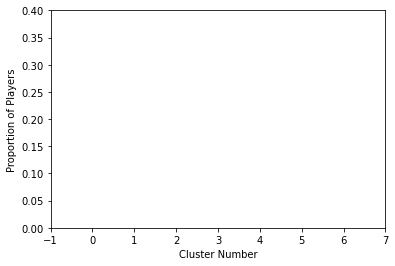

In [18]:
num_clusters = len(np.unique(clusters))
fig, ax = plt.subplots()

ax.set_xlabel('Cluster Number')
ax.set_xlim(( -1, num_clusters))
ax.set_ylabel('Proportion of Players')
ax.set_ylim((0, .4))

bar = ax.bar(np.arange(0,num_clusters),np.zeros(num_clusters))

In [19]:
def animate_player_percentage(i):
    year = season_minutes_by_cluster['SEASON_YEAR'].unique()[i]
    data = season_minutes_by_cluster[season_minutes_by_cluster['SEASON_YEAR'] == year][['cluster','PLAYER_%']].to_numpy()
    
    for i in range(len(data[:,0])):
        bar[i].set_height(data[:,1][i])

    ax.set_title(year)
    
    return bar

anim=animation.FuncAnimation(fig,animate_player_percentage,repeat=False,blit=False,frames=21,
                             interval=1000)

HTML(anim.to_html5_video())

Interestingly, 3 has been abundant FILL IN

Will we see an even clearer trend if we take the 10 winningest teams each season?

In [20]:
team_win_loss = game_logs_data_with_clusters[['SEASON_YEAR','TEAM_ID','TEAM_NAME','GAME_ID','WL']].drop_duplicates()

In [21]:
team_win_loss_records = team_win_loss.groupby(by=['SEASON_YEAR','TEAM_NAME','WL']).size().reset_index().pivot_table(index=['SEASON_YEAR','TEAM_NAME'],columns='WL',values=0)
team_win_loss_records = team_win_loss_records.reset_index()
team_win_loss_records['win_%'] = team_win_loss_records['W'] / (team_win_loss_records['W'] + team_win_loss_records['L'])
team_win_loss_records.sample(3)

WL,SEASON_YEAR,TEAM_NAME,L,W,win_%
278,2009-10,Los Angeles Lakers,25,57,0.695122
163,2005-06,New Jersey Nets,33,49,0.597561
147,2005-06,Boston Celtics,49,33,0.402439


In [22]:
top_teams = team_win_loss_records.sort_values(by='win_%', ascending=False).groupby('SEASON_YEAR').head(10)
top_teams.sort_values(by=['SEASON_YEAR','win_%'],ascending=[True,False],inplace=True)
top_teams

WL,SEASON_YEAR,TEAM_NAME,L,W,win_%
23,2000-01,San Antonio Spurs,24,58,0.707317
12,2000-01,Los Angeles Lakers,26,56,0.682927
19,2000-01,Philadelphia 76ers,26,56,0.682927
22,2000-01,Sacramento Kings,27,55,0.670732
5,2000-01,Dallas Mavericks,29,53,0.646341
...,...,...,...,...,...
608,2020-21,LA Clippers,25,47,0.652778
612,2020-21,Milwaukee Bucks,26,46,0.638889
609,2020-21,Los Angeles Lakers,30,42,0.583333
602,2020-21,Dallas Mavericks,30,42,0.583333


In [23]:
top_teams_filter = game_logs_data_with_clusters[['SEASON_YEAR', 'TEAM_NAME']].apply(tuple, axis=1).isin(top_teams[['SEASON_YEAR', 'TEAM_NAME']].apply(tuple, axis=1))

top_teams_season_minutes_by_cluster = game_logs_data_with_clusters[top_teams_filter].groupby(['SEASON_YEAR','cluster']).agg({'MIN':'sum','PLAYER_NAME':lambda x: x.nunique()}).reset_index()

for year in top_teams_season_minutes_by_cluster['SEASON_YEAR'].unique():
    year_filter = top_teams_season_minutes_by_cluster['SEASON_YEAR'] == year
    total_mins = top_teams_season_minutes_by_cluster[year_filter]['MIN'].sum()
    top_teams_season_minutes_by_cluster.loc[year_filter,'MIN_%'] = top_teams_season_minutes_by_cluster[year_filter]['MIN']/total_mins
    total_players = top_teams_season_minutes_by_cluster[year_filter]['PLAYER_NAME'].sum()
    top_teams_season_minutes_by_cluster.loc[year_filter,'PLAYER_%'] = top_teams_season_minutes_by_cluster[year_filter]['PLAYER_NAME']/total_players

In [24]:
def animate_top(i):
    year = top_teams_season_minutes_by_cluster['SEASON_YEAR'].unique()[i]
    data = top_teams_season_minutes_by_cluster[top_teams_season_minutes_by_cluster['SEASON_YEAR'] == year][['cluster','MIN_%']].to_numpy()
    
    for i in range(len(data[:,0])):
        bar[i].set_height(data[:,1][i])
    
    ax.set_title(year)
    
    return bar

In [25]:
anim=animation.FuncAnimation(fig,animate_top,repeat=False,blit=False,frames=21,
                             interval=1000)

In [26]:
HTML(anim.to_html5_video())

This doesn't seem to be too different from the overall league which implies that the winning teams were not that far ahead of the curve in terms of strategy. Let's look at the overall change from the first 3 seasons in our dataset to the last 3 seasons. 

In [27]:
compare_before_filter = (season_minutes_by_cluster['SEASON_YEAR']=='2000-01')|(season_minutes_by_cluster['SEASON_YEAR']=='2001-02')|(season_minutes_by_cluster['SEASON_YEAR']=='2002-03')
compare_after_filter = (season_minutes_by_cluster['SEASON_YEAR']=='2018-19')|(season_minutes_by_cluster['SEASON_YEAR']=='2019-20')|(season_minutes_by_cluster['SEASON_YEAR']=='2020-21')

In [28]:
compare_before_df = season_minutes_by_cluster[compare_before_filter].groupby('cluster').mean()
compare_before_df.columns = ['MIN_BEF','PLAYERS_BEF','MIN_%_BEF','PLAYER_%_BEF']
compare_after_df = season_minutes_by_cluster[compare_after_filter].groupby('cluster').mean()
compare_after_df.columns = ['MIN_AFT','PLAYERS_AFT','MIN_%_AFT','PLAYER_%_AFT']

compare_df = pd.concat([compare_before_df,compare_after_df],axis=1)

compare_df['MIN_%_DIFF'] = (compare_df['MIN_%_AFT'] - compare_df['MIN_%_BEF'])/compare_df['MIN_%_BEF']

compare_df['cluster_name'] = [cluster_labels[index_value] for index_value in compare_df.index]

compare_df

,MIN_BEF,PLAYERS_BEF,MIN_%_BEF,PLAYER_%_BEF,MIN_AFT,PLAYERS_AFT,MIN_%_AFT,PLAYER_%_AFT,MIN_%_DIFF,cluster_name
cluster,,,,,,,,,,
0.0,5193.838333,19.000000,0.009916,0.054099,1152.767778,15.000000,0.002172,0.030667,-0.781013,Situational/Defensive Players
1.0,77757.817778,28.000000,0.148988,0.079840,94186.544444,48.333333,0.178674,0.098916,0.199253,High Usage Dominant Scorers
2.0,111598.758889,66.000000,0.213850,0.187923,94278.483889,91.000000,0.177321,0.185982,-0.170816,Stretch Forward
3.0,69882.572222,82.666667,0.133833,0.235583,45568.635000,83.666667,0.086426,0.171643,-0.354224,Low End All Around Players
4.0,118461.957222,71.000000,0.226535,0.201815,71954.101111,58.000000,0.135502,0.119041,-0.401849,Playmakers
5.0,76872.809444,48.000000,0.147221,0.136365,174378.317778,144.000000,0.329320,0.294737,1.236907,3 Point Specialist
6.0,62544.821667,36.666667,0.119657,0.104376,47670.762778,48.333333,0.090585,0.099014,-0.242961,Traditional Big Men


In [29]:
top_teams_compare_before_df = top_teams_season_minutes_by_cluster[compare_before_filter].groupby('cluster').mean()
top_teams_compare_before_df.columns = ['MIN_BEF','PLAYERS_BEF','MIN_%_BEF','PLAYER_%_BEF']
top_teams_compare_after_df = top_teams_season_minutes_by_cluster[compare_after_filter].groupby('cluster').mean()
top_teams_compare_after_df.columns = ['MIN_AFT','PLAYERS_AFT','MIN_%_AFT','PLAYER_%_AFT']

top_teams_compare_df = pd.concat([top_teams_compare_before_df,top_teams_compare_after_df],axis=1)

top_teams_compare_df['MIN_%_DIFF'] = (top_teams_compare_df['MIN_%_AFT'] - top_teams_compare_df['MIN_%_BEF'])/top_teams_compare_df['MIN_%_BEF']

top_teams_compare_df['cluster_name'] = [cluster_labels[index_value] for index_value in top_teams_compare_df.index]

top_teams_compare_df

,MIN_BEF,PLAYERS_BEF,MIN_%_BEF,PLAYER_%_BEF,MIN_AFT,PLAYERS_AFT,MIN_%_AFT,PLAYER_%_AFT,MIN_%_DIFF,cluster_name
cluster,,,,,,,,,,
0.0,1226.358333,5.666667,0.006718,0.044296,254.033889,4.000000,0.001438,0.022244,-0.785957,Situational/Defensive Players
1.0,30144.853333,11.000000,0.164919,0.086088,38794.533333,19.333333,0.218567,0.108750,0.325299,High Usage Dominant Scorers
2.0,35554.632222,23.333333,0.194226,0.182901,26522.409444,32.000000,0.147871,0.178512,-0.238664,Stretch Forward
3.0,24604.726111,33.000000,0.134378,0.258779,16433.670000,33.000000,0.092864,0.186886,-0.308932,Low End All Around Players
4.0,43877.006667,25.666667,0.239786,0.201028,24452.570000,21.333333,0.136380,0.119277,-0.431242,Playmakers
5.0,28139.189444,17.666667,0.154010,0.138113,55754.843333,53.333333,0.314080,0.297163,1.039349,3 Point Specialist
6.0,19395.186111,11.333333,0.105963,0.088794,15689.340000,15.666667,0.088799,0.087167,-0.161984,Traditional Big Men


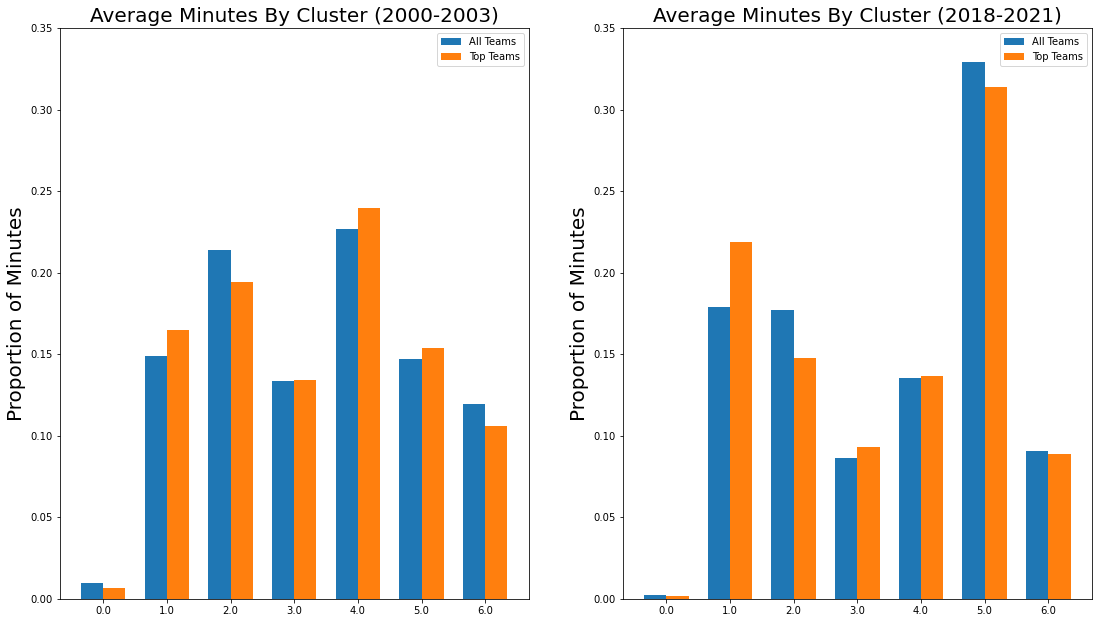

In [30]:
labels = top_teams_compare_df.index.to_list()

top_teams_cluster_mins_bef = top_teams_compare_df['MIN_%_BEF']
top_teams_cluster_mins_aft = top_teams_compare_df['MIN_%_AFT']

cluster_mins_bef = compare_df['MIN_%_BEF']
cluster_mins_aft = compare_df['MIN_%_AFT']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_size_inches(18.5, 10.5)

rects1 = ax1.bar(x - width/2, cluster_mins_bef, width, label='All Teams')
rects2 = ax1.bar(x + width/2, top_teams_cluster_mins_bef, width, label='Top Teams')

rects3 = ax2.bar(x - width/2, cluster_mins_aft, width, label='All Teams')
rects4 = ax2.bar(x + width/2, top_teams_cluster_mins_aft, width, label='Top Teams')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Proportion of Minutes',size=20)
ax1.set_title('Average Minutes By Cluster (2000-2003)',size=20)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_ylim(0,.35)
ax1.legend()

ax2.set_ylabel('Proportion of Minutes',size=20)
ax2.set_title('Average Minutes By Cluster (2018-2021)',size=20)
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.set_ylim(0,.35)
ax2.legend()

Let's do a little data exploration and prep prior to the win rate prediction.

In [31]:
game_logs_data.head(5)

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,2000-01,2053,Dalibor Bagaric,Dalibor,1610612741,CHI,Chicago Bulls,0020001181,2001-04-18T00:00:00,CHI @ PHI,...,0.0,0.500,0.521,0.158,0.161,94.29,96.51,80.43,19,0.113
1,2000-01,397,Reggie Miller,Reggie,1610612754,IND,Indiana Pacers,0020001184,2001-04-18T00:00:00,IND @ CLE,...,0.0,0.559,0.600,0.295,0.294,100.17,99.41,82.84,58,0.137
2,2000-01,469,Jamal Mashburn,Jamal,1610612766,CHH,Charlotte Hornets,0020001179,2001-04-18T00:00:00,CHH @ BOS,...,12.1,0.357,0.436,0.326,0.329,93.51,91.37,76.14,69,0.118
3,2000-01,1088,Chucky Atkins,Chucky,1610612765,DET,Detroit Pistons,0020001180,2001-04-18T00:00:00,DET @ NYK,...,0.0,0.222,0.253,0.164,0.163,100.13,99.19,82.66,57,0.048
4,2000-01,1890,Shawn Marion,Shawn,1610612756,PHX,Phoenix Suns,0020001187,2001-04-18T00:00:00,PHX vs. UTA,...,0.0,0.600,0.680,0.130,0.136,86.04,83.34,69.45,40,0.179


In [32]:
# team_game_logs = pd.read_csv('2000-2021 Season Team Game Logs.csv',index_col=0,dtype={'GAME_ID':'str'})[['SEASON_YEAR', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
#        'GAME_DATE', 'MATCHUP', 'WL', 'MIN','PTS']]

In [33]:
# game_logs_data_with_clusters['GAME_MONTH'] = game_logs_data_with_clusters['GAME_DATE'].str[:7]
# game_logs_data_with_clusters['OPP'] = game_logs_data_with_clusters['MATCHUP'].str[-3:]

# monthly_team_win_loss = game_logs_data_with_clusters[['SEASON_YEAR','TEAM_ID','TEAM_NAME','TEAM_ABBREVIATION','GAME_MONTH','GAME_ID','WL']].drop_duplicates()

# monthly_team_win_loss_records = monthly_team_win_loss.groupby(by=['SEASON_YEAR','GAME_MONTH','TEAM_NAME','TEAM_ABBREVIATION','WL']).size().reset_index().pivot_table(index=['SEASON_YEAR','GAME_MONTH','TEAM_NAME','TEAM_ABBREVIATION'],columns='WL',values=0)
# monthly_team_win_loss_records = monthly_team_win_loss_records.reset_index()
# monthly_team_win_loss_records['win_%'] = monthly_team_win_loss_records['W'] / (monthly_team_win_loss_records['W'] + monthly_team_win_loss_records['L'])

# monthly_team_win_loss_records.fillna(0,inplace=True)

In [34]:
# # creating baseline for prediction - win rate up to the month

# monthly_team_win_loss_records = monthly_team_win_loss_records.reset_index(drop=True)
# monthly_team_win_loss_records['GAME_MONTH_DATE'] = pd.to_datetime(monthly_team_win_loss_records['GAME_MONTH'])

# for row_index in range(len(monthly_team_win_loss_records)):
#     current_year = monthly_team_win_loss_records.loc[row_index,'SEASON_YEAR']
#     current_team = monthly_team_win_loss_records.loc[row_index,'TEAM_NAME']
#     current_month_date = monthly_team_win_loss_records.loc[row_index,'GAME_MONTH_DATE']
    
#     year_filter = monthly_team_win_loss_records['SEASON_YEAR'] == current_year
#     team_filter = monthly_team_win_loss_records['TEAM_NAME'] == current_team
#     month_filter = monthly_team_win_loss_records['GAME_MONTH_DATE'] < current_month_date
#     combined_filter = (year_filter)&(team_filter)&(month_filter)
    
#     if len(monthly_team_win_loss_records[combined_filter])>0:
#         num_losses = sum(monthly_team_win_loss_records[combined_filter]['L'])
#         num_wins = sum(monthly_team_win_loss_records[combined_filter]['W'])
#         cumulative_win_percent = num_wins/(num_wins + num_losses)
#     else:
#         # use an estimate if first month of the season
#         cumulative_win_percent = .5
        
#     monthly_team_win_loss_records.loc[row_index,'cumulative_win_%'] = cumulative_win_percent
    


In [35]:
# monthly_team_win_loss_records.sample(5)

WL,SEASON_YEAR,GAME_MONTH,TEAM_NAME,TEAM_ABBREVIATION,L,W,win_%,GAME_MONTH_DATE,cumulative_win_%
1214,2006-07,2006-12,Los Angeles Lakers,LAL,6.0,10.0,0.625000,2006-12-01,0.666667
173,2000-01,2001-04,Charlotte Hornets,CHH,4.0,6.0,0.600000,2001-04-01,0.555556
2141,2010-11,2011-03,New Orleans Hornets,NOH,6.0,8.0,0.571429,2011-03-01,0.573770
2882,2014-15,2015-02,Minnesota Timberwolves,MIN,6.0,5.0,0.454545,2015-02-01,0.170213
2228,2011-12,2012-01,Milwaukee Bucks,MIL,10.0,7.0,0.411765,2012-01-01,0.666667


In [36]:
# # for exploration
# monthly_team_cluster_data = game_logs_data_with_clusters.groupby(by=['GAME_MONTH','TEAM_ABBREVIATION','cluster']).agg({'PLAYER_NAME':['count'],'MIN':['sum','mean'],'PTS':['sum','mean']})

# #append if there was a multiindex
# monthly_team_cluster_data.columns = [col_name[0] + ("_"*(len(col_name[1])>0)) + col_name[1] for col_name in monthly_team_cluster_data.columns]

# # create cluster percentage

# monthly_team_cluster_data["MIN_%"]= 0

# unique_monthly_records = list(set([(index_value[0],index_value[1]) for index_value in monthly_team_cluster_data.index.to_list()]))

# for team_month in unique_monthly_records:
#     total_minutes = monthly_team_cluster_data.loc[team_month]['MIN_sum'].sum()
#     for cluster_no in cluster_labels.keys():
#         try:
#             min_percent = monthly_team_cluster_data.loc[(team_month[0],team_month[1],cluster_no),"MIN_sum"]/total_minutes
#             monthly_team_cluster_data.loc[(team_month[0],team_month[1],cluster_no),'MIN_%'] = min_percent
#         except: # if cluster doesn't already exist
#             monthly_team_cluster_data.loc[(team_month[0],team_month[1],cluster_no),'MIN_%'] = 0

C:\Users\arthu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2894: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(
<ipython-input-36-0c38922acbcf>:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  total_minutes = monthly_team_cluster_data.loc[team_month]['MIN_sum'].sum()


In [37]:
# monthly_team_cluster_data = monthly_team_cluster_data.sort_index().reset_index()
# monthly_team_cluster_data.head(7)

,GAME_MONTH,TEAM_ABBREVIATION,cluster,PLAYER_NAME_count,MIN_sum,MIN_mean,PTS_sum,PTS_mean,MIN_%
0,2000-10,ATL,0.0,NaN,NaN,NaN,NaN,NaN,0.000000
1,2000-10,ATL,1.0,NaN,NaN,NaN,NaN,NaN,0.000000
2,2000-10,ATL,2.0,1.0,35.900000,35.900000,23.0,23.000000,0.151455
3,2000-10,ATL,3.0,5.0,101.733333,20.346667,21.0,4.200000,0.429194
4,2000-10,ATL,4.0,3.0,70.550000,23.516667,17.0,5.666667,0.297637
5,2000-10,ATL,5.0,1.0,28.850000,28.850000,21.0,21.000000,0.121713
6,2000-10,ATL,6.0,NaN,NaN,NaN,NaN,NaN,0.000000


In [38]:
# # get opponent w/l records and minutes

# opp_records = game_logs_data_with_clusters[['SEASON_YEAR','TEAM_ID','TEAM_NAME','TEAM_ABBREVIATION','GAME_MONTH','GAME_ID','OPP']].drop_duplicates()
# opp_records = pd.merge(opp_records,monthly_team_win_loss_records[['GAME_MONTH','TEAM_ABBREVIATION','cumulative_win_%']],how='left',left_on=['GAME_MONTH','OPP'],right_on=['GAME_MONTH','TEAM_ABBREVIATION'],suffixes=('','_2'),validate="m:1")
# opp_records = opp_records.groupby(by=['GAME_MONTH','TEAM_ABBREVIATION']).agg({'cumulative_win_%':'mean'})

# opp_records.reset_index(inplace=True)
# opp_records.columns = ['GAME_MONTH','TEAM_ABBREVIATION','opp_avg_cumulative_win_%']

In [39]:
# monthly_team_win_loss_records= pd.merge(monthly_team_win_loss_records,opp_records,on=['GAME_MONTH','TEAM_ABBREVIATION'])

In [40]:
# final_monthly_data = pd.merge(monthly_team_win_loss_records,monthly_team_cluster_data,  how='left', left_on=['GAME_MONTH','TEAM_ABBREVIATION'], right_on=['GAME_MONTH','TEAM_ABBREVIATION'])
# final_monthly_data.to_csv('monthly_win_rates_and_cluster_data.csv')
# final_monthly_data.head()


,SEASON_YEAR,GAME_MONTH,TEAM_NAME,TEAM_ABBREVIATION,L,W,win_%,GAME_MONTH_DATE,cumulative_win_%,opp_avg_cumulative_win_%,cluster,PLAYER_NAME_count,MIN_sum,MIN_mean,PTS_sum,PTS_mean,MIN_%
0,2000-01,2000-10,Atlanta Hawks,ATL,1.0,0.0,0.0,2000-10-01,0.5,0.5,0.0,NaN,NaN,NaN,NaN,NaN,0.000000
1,2000-01,2000-10,Atlanta Hawks,ATL,1.0,0.0,0.0,2000-10-01,0.5,0.5,1.0,NaN,NaN,NaN,NaN,NaN,0.000000
2,2000-01,2000-10,Atlanta Hawks,ATL,1.0,0.0,0.0,2000-10-01,0.5,0.5,2.0,1.0,35.900000,35.900000,23.0,23.000000,0.151455
3,2000-01,2000-10,Atlanta Hawks,ATL,1.0,0.0,0.0,2000-10-01,0.5,0.5,3.0,5.0,101.733333,20.346667,21.0,4.200000,0.429194
4,2000-01,2000-10,Atlanta Hawks,ATL,1.0,0.0,0.0,2000-10-01,0.5,0.5,4.0,3.0,70.550000,23.516667,17.0,5.666667,0.297637


In [41]:
# final_monthly_data.columns

Index(['SEASON_YEAR', 'GAME_MONTH', 'TEAM_NAME', 'TEAM_ABBREVIATION', 'L', 'W',
       'win_%', 'GAME_MONTH_DATE', 'cumulative_win_%',
       'opp_avg_cumulative_win_%', 'cluster', 'PLAYER_NAME_count', 'MIN_sum',
       'MIN_mean', 'PTS_sum', 'PTS_mean', 'MIN_%'],
      dtype='object')